# Data-based analysis of Vienna's Airbnb listings
This file was created in the course of my Udacity Data Scientist Nanodegree program. A data analysis on data from Airbnb is performed to gain insights into Vienna's Airbnb listings. Note that this notebook can be applied to data from other Airbnb locations as well, assuming that the data structure is similar. You can download latests datasets for other locations/cities from [Airbnb website](http://insideairbnb.com/get-the-data/).


## Business Understanding

This notebook was created in the course of my Udacity Data Scientist Nanodegree program. In this first project we were asked to analyze a dataset of our own choice. As a proud Austrian, I picked a data set related to Austria. I selected an Airbnb dataset regarding the available listings in Vienna and tried to answer the following questions:

* Basic Listings Statistics: How many Airbnb listings are offered for Vienna, and how do they split up in private rooms, entire homes/apartments, hotel rooms and shared rooms? What is the price distribution across the room types?  

* Hosts Statistics: How many hosts offer their listings on Airbnb? Are there more hosts which offer a single listing or hosts which offer multiple listings on Airbnb?  

* Private vs. Professional Hosts: Are there any obvious differences in the listings attributes (e.g. prices, review ratings), comparing the single host listings with the listings from hosts with multiple offers?

In [78]:
# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# plot and rendering settings
pio.renderers.default = "png"
%matplotlib notebook

# optical benefits
pd.set_option('float_format', '{:.2f}'.format)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Data Understanding

In [79]:
# import data
df_listings_details = pd.read_csv('./data/listings.csv.gz')

In [80]:
# explore structure of the dataframe
print('Number of Rows (number of listings):', df_listings_details.shape[0])
print('Number of Columns:', df_listings_details.shape[1])

Number of Rows (number of listings): 11797
Number of Columns: 75


In [81]:
# print available columns
df_listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [107]:
# show basic info
df_listings_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11797 entries, 0 to 11796
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11797 non-null  int64  
 1   listing_url                                   11797 non-null  object 
 2   scrape_id                                     11797 non-null  int64  
 3   last_scraped                                  11797 non-null  object 
 4   source                                        11797 non-null  object 
 5   name                                          11785 non-null  object 
 6   description                                   11550 non-null  object 
 7   neighborhood_overview                         6498 non-null   object 
 8   picture_url                                   11797 non-null  object 
 9   host_id                                       11797 non-null 

In [82]:
# check for missing values
df_listings_details.isna().any()

id                                              False
listing_url                                     False
scrape_id                                       False
last_scraped                                    False
source                                          False
                                                ...  
calculated_host_listings_count                  False
calculated_host_listings_count_entire_homes     False
calculated_host_listings_count_private_rooms    False
calculated_host_listings_count_shared_rooms     False
reviews_per_month                                True
Length: 75, dtype: bool

The dataframe has columns with missing values. We will take care about this later, if necessary.

In [83]:
# print price statistics for the room types
df_listings_details.groupby('room_type')['price'].describe()

,count,unique,top,freq
room_type,,,,
Entire home/apt,9090,405,$70.00,253
Hotel room,56,45,$110.00,3
Private room,2575,193,$30.00,157
Shared room,76,42,$30.00,7


## Data Preparation

In [84]:
# convert prices to float
df_listings_details['price'] = df_listings_details['price'].str[1:].replace(',', '', regex=True).astype(float)

### Basic Listings Statistics

In [85]:
# check for missing values for basic listings statistics
print('Room type missing values: ', df_listings_details['room_type'].isna().any())
print('Price missing values: ', df_listings_details['price'].isna().any())

Room type missing values:  False
Price missing values:  False


In [86]:
# prepare data for basic listings statistics
basic_listings_stats_series = df_listings_details['room_type'].value_counts()
basic_listings_stats = pd.DataFrame({'Room Type': basic_listings_stats_series.index, 'Number of Listings': basic_listings_stats_series.values})

In [108]:
# add percent columns to dataframe and show dataframe
def calculate_perc(row):
    """Calculated the percentage value for the passed row 

    Input:
        row: single row dataframe passed by the apply function

    Output:
        percentage value for the specific row
    """
    return row['Number of Listings']/sum(basic_listings_stats['Number of Listings'])*100

basic_listings_stats['Percent of Total'] = basic_listings_stats.apply(calculate_perc, axis=1)

### Host Statistics

In [88]:
# check for missing for host statistics
print('Host ID missing values: ', df_listings_details['host_id'].isna().any())
print('Host listings count missing values: ', df_listings_details['calculated_host_listings_count'].isna().any())
print('Room Type missing values: ', df_listings_details['room_type'].isna().any())
print('Prince missing values: ', df_listings_details['price'].isna().any())

Host ID missing values:  False
Host listings count missing values:  False
Room Type missing values:  False
Prince missing values:  False


In [89]:
# create dataframe for hosts statistics
df_listings_counts = df_listings_details[['host_id', 'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_shared_rooms']].drop_duplicates()

In [90]:
# create sorted dataframe for host statistics
df_listings_counts_sorted = df_listings_counts.sort_values('calculated_host_listings_count', ascending=False)

### Private vs. Professional Hosts

In [91]:
# check for missing values for private vs professional analysis
print('Host ID missing values: ', df_listings_details['host_id'].isna().any())
print('Host listings count missing values: ', df_listings_details['calculated_host_listings_count'].isna().any())
print('Room Type missing values: ', df_listings_details['room_type'].isna().any())
print('Prince missing values: ', df_listings_details['price'].isna().any())
print('Availability missing values: ', df_listings_details['availability_365'].isna().any())
print('Number of reviews missing values: ', df_listings_details['number_of_reviews_ltm'].isna().any())
print('Minimum nights missing values: ', df_listings_details['minimum_nights'].isna().any())
print('Maximum nights missing values: ', df_listings_details['maximum_nights'].isna().any())

Host ID missing values:  False
Host listings count missing values:  False
Room Type missing values:  False
Prince missing values:  False
Availability missing values:  False
Number of reviews missing values:  False
Minimum nights missing values:  False
Maximum nights missing values:  False


In [92]:
# filter listings from private and professional hosts and entire home / department listings for private vs professional analysis
professional_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] >= 5) & (df_listings_details['room_type'] == 'Entire home/apt')]
private_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] == 1) & (df_listings_details['room_type'] == 'Entire home/apt')]
#professional_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] >= 5)]
#private_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] == 1)]

In [93]:
# create dataframe for private vs professional analysis
professional_vs_private = pd.DataFrame(columns=['metric', 'professional_hosts', 'private_hosts'])
data = pd.DataFrame({'metric': ['number_of_hosts', 'total_listings', 'mean_price', 'mean_availability', 'review_scores_rating'],
                        'professional_hosts': [professional_hosts['host_id'].nunique(), professional_hosts.shape[0], professional_hosts['price'].mean(), professional_hosts['availability_365'].mean(),  professional_hosts['review_scores_rating'].mean()],
                        'private_hosts': [private_hosts['host_id'].nunique(), private_hosts.shape[0], private_hosts['price'].mean(), private_hosts['availability_365'].mean(), private_hosts['review_scores_rating'].mean()]}) 

professional_vs_private = pd.concat([professional_vs_private, data])

## Evaluation

### Basic Listings Statistics
How many Airbnb listings are offered for Vienna, and how do they split up in private rooms, entire homes/apartments, hotel rooms and shared rooms? What is the price distribution across the room types?

In [94]:
# count number of listings
print('Number of listings:', df_listings_details.shape[0])

Number of listings: 11797


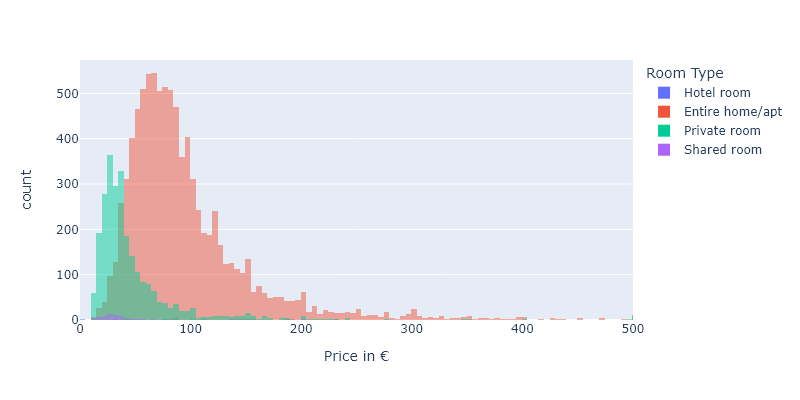

In [95]:
# plot price distribution
fig = px.histogram(df_listings_details, x="price", color="room_type", barmode="overlay", labels=dict(price="Price in €", room_type="Room Type"), width=800, height=400, nbins=2000)
fig.update_xaxes(range=[0, 500])
fig.show()

In [96]:
# show mean prices for each room type
df_listings_details.groupby('room_type')['price'].mean()

room_type
Entire home/apt   105.16
Hotel room        137.73
Private room       60.10
Shared room        43.24
Name: price, dtype: float64

In [112]:
# dataframe with basics statistics
basic_listings_stats

,Room Type,Number of Listings,Percent of Total
0,Entire home/apt,9090,77.05
1,Private room,2575,21.83
2,Shared room,76,0.64
3,Hotel room,56,0.47


**Conclusions**:
* There are 11.797 listings on Airbnb for Vienna. The majority, around 77% are entire homes or departments. 22% are private rooms. You are likely to get an entire home or a department for less than € 100,- for a night.
* Shared rooms and hotel rooms are both below 1%, and therefore play a negligible role.


### Hosts Statistics
How many hosts offer their listings on Airbnb? Are there more hosts which offer a single listing or hosts which offer multiple listings on Airbnb? 

In [97]:
# print number of hosts and listings with consistency checks
print('Number of Hosts: ', df_listings_details['host_id'].nunique())
print('Number of Hosts: ', df_listings_counts['host_id'].shape[0]) # check if consistent
print('Number of Listings: ', df_listings_details['id'].nunique())
print('Number of Listings: ', sum(df_listings_counts['calculated_host_listings_count'])) # check if consistent

Number of Hosts:  6514
Number of Hosts:  6514
Number of Listings:  11797
Number of Listings:  11797


In [98]:
# show number of hosts with 1 listing
print('Number of hosts with a single listing: ', df_listings_counts_sorted['calculated_host_listings_count'].value_counts().iloc[0])

Number of hosts with a single listing:  5170


In [99]:
# show number of listing for the host with most listings
print('Number of listings (host with most listings): ', df_listings_counts_sorted['calculated_host_listings_count'].iloc[0])
print('Number of listings (host with second most listings): ', df_listings_counts_sorted['calculated_host_listings_count'].iloc[1])

Number of listings (host with most listings):  209
Number of listings (host with second most listings):  123


In [121]:
df_listings_counts['calculated_host_listings_count']

0         4
1         3
2        15
3         4
6         3
         ..
11790     1
11791     1
11792     1
11793     1
11795     1
Name: calculated_host_listings_count, Length: 6514, dtype: int64

In [100]:
# prepare data for pie plot
df_pie_0_4 = df_listings_counts['calculated_host_listings_count'].value_counts()[:4]
df_pie_4_ = df_listings_counts['calculated_host_listings_count'].value_counts()[4:].sum()

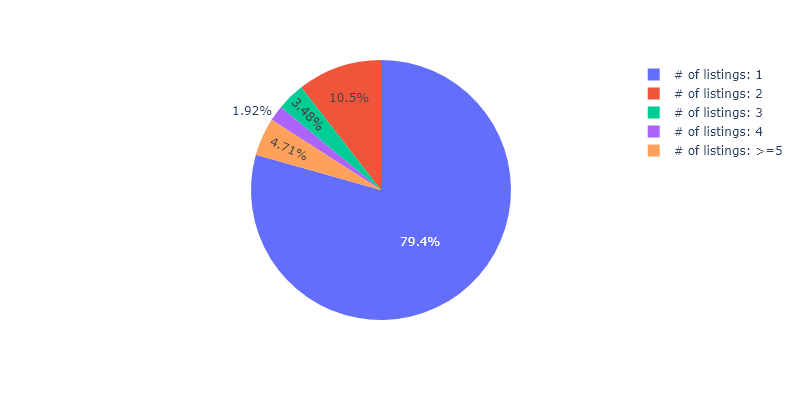

In [101]:
# pie plot for number of listings per host
names = ['# of listings: ' + str(df_pie_0_4.index[i]) for i in range(4)]
names.append('# of listings: >=5')
fig = px.pie(values=np.append(df_pie_0_4.values, df_pie_4_), names=names, width=800, height=400)
fig.update_traces(sort=False, selector=dict(type='pie'))
fig.show()

In [102]:
# plot number of hosts
print('Number of hosts: ', df_listings_counts['host_id'].nunique())


Number of hosts:  6514


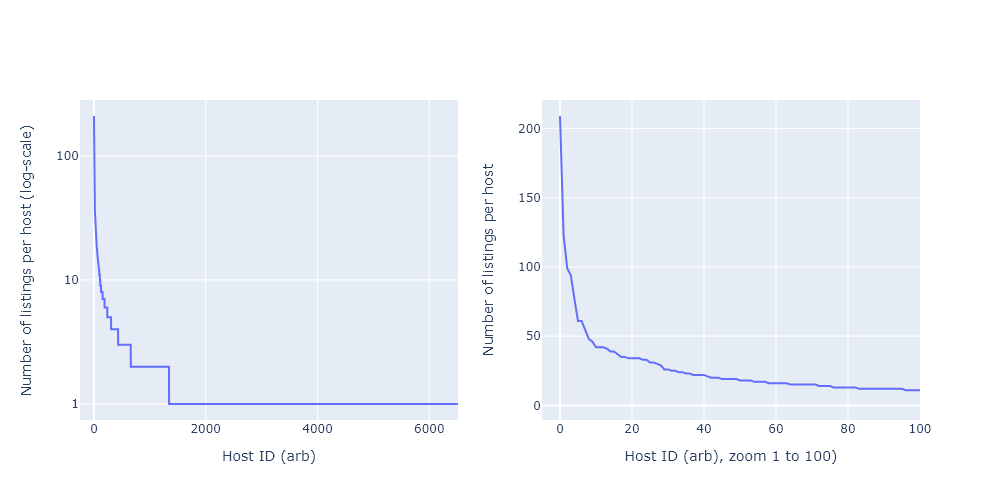

In [103]:
# plot number of listings vs host id

fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

fig.add_trace(go.Scatter(y=df_listings_counts_sorted['calculated_host_listings_count'], marker_color='#636EFA'), 1, 1)
fig.add_trace(go.Scatter(y=df_listings_counts_sorted['calculated_host_listings_count'], marker_color='#636EFA'), 1, 2)

fig.update_xaxes(title_text="Host ID (arb)", row=1, col=1)
fig.update_xaxes(title_text="Host ID (arb), zoom 1 to 100)", row=1, col=2)
fig.update_xaxes(range=[-250, df_listings_counts['host_id'].shape[0]], row=1, col=1)
fig.update_xaxes(range=[-5, 100], row=1, col=2)
b
fig.update_yaxes(title_text="Number of listings per host (log-scale)", type="log", tickvals=[0, 1, 10, 100],  row=1, col=1)
fig.update_yaxes(title_text="Number of listings per host", row=1, col=2)

fig.update_layout(showlegend=False)
fig.update_layout(autosize=False, width=1000, height=500)
fig.show()

In [143]:
print('Total number of listings from hosts with >=5 listings: ', sum(df_listings_counts_sorted[df_listings_counts_sorted['calculated_host_listings_count'] >=5]['calculated_host_listings_count']))
print('Total number of listings from hosts with 1 listing: ', sum(df_listings_counts_sorted[df_listings_counts_sorted['calculated_host_listings_count'] ==1]['calculated_host_listings_count']))

Total number of listings from hosts with >=5 listings:  4076
Total number of listings from hosts with 1 listing:  5170


**Conclusions:**
* 6.514 hosts offer their homes or departments on Airbnb. 79,4% of the hosts just offer a single listing. 4,71% of the hosts offer 5 listings or more.
* There is number of hosts which offer quit a large number of listings. One host offers even a number of 209 listings. The second largest number of listings are 123 from a single host.
* The hosts with 5 or more listing offer altogether a total number of 4.076 listings, where the hosts with just one listing offer a total number of 5.170 listings.

### Private vs. Professional Hosts
Are there any obvious differences in the listings attributes (e.g. prices, review ratings), comparing the single host listings with the listings from hosts with multiple offers?

In [104]:
# prepare a dataframe for the plots
professional_vs_private_melted = pd.melt(professional_vs_private, id_vars=['metric'], value_vars=['professional_hosts', 'private_hosts'], var_name='host_type')

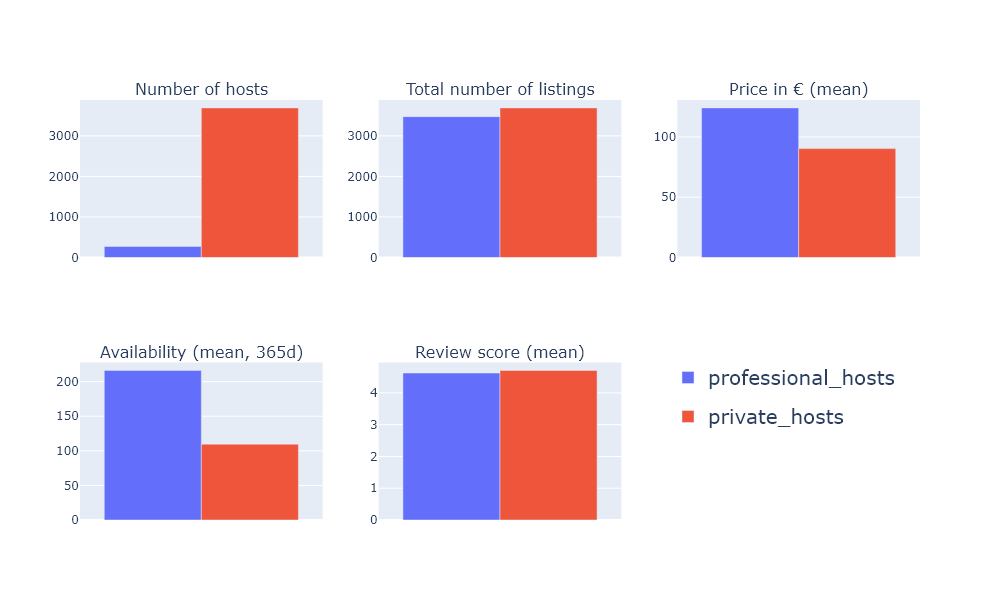

In [149]:
# plot professional vs private host comparison

columns = ['number_of_hosts', 'total_listings', 'mean_price', 'mean_availability', 'review_scores_rating']
plot_titles = ['Number of hosts', 'Total number of listings', 'Price in € (mean)', 'Availability (mean, 365d)', 'Review score (mean)']
host_types = ['professional_hosts', 'private_hosts']

fig = make_subplots(rows=2, cols=3, shared_yaxes=False, subplot_titles=plot_titles)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[0])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=True), 1, 1)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[0])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=True), 1, 1)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[1])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 1, 2)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[1])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 1, 2)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[2])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False),1, 3)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[2])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 1, 3)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[3])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 2, 1)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[3])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 2, 1)
                        
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[4])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 2, 2)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[4])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 2, 2)
                        
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=True)
fig.update_layout(autosize=False, width=1000, height=600)
fig.update_layout(legend=dict(y=0.20, x=0.70, font=dict(size=20)))
fig.show()

**Conclusions:**
* There are approximately the same number of homes or apartments offered by private hosts and by professional hosts.
* Where as the mean review scores are approximately similar for homes or departments from private and professional hosts, there are differences in the availability and the price.